### 1. Importing the Libraries

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential
from keras.utils.np_utils import to_categorical


### 2.a Loading the data

In [125]:
df_X_train = pd.read_csv('./dataset/train/images.csv')
df_y_train = pd.read_csv('./dataset/train/labels.csv')

df_X_test = pd.read_csv('./dataset/valid/images (1).csv')
df_y_test = pd.read_csv('./dataset/valid/labels (1).csv')

### 2.b Shape of training and validation data

In [126]:
print(f"Shape of df_X_train: {df_X_train.shape}")
print(f"Shape of df_y_train: {df_y_train.shape}")
print(f"Shape of df_X_test: {df_X_test.shape}")
print(f"Shape of df_y_test: {df_y_test.shape}")

Shape of df_X_train: (3199, 8192)
Shape of df_y_train: (3199, 4)
Shape of df_X_test: (799, 8192)
Shape of df_y_test: (799, 4)


In [127]:
noise_classes = ["squiggle", "narrowband", "narrowbanddrd", "noise"]

In [128]:
noise_classes[np.argmax(df_y_train.iloc[0])]

'squiggle'

### Visualizing the dataset

narrowbanddrd


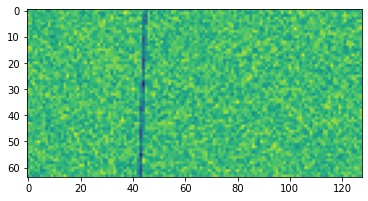

In [129]:
# Choosing the shape of the image as 64 * 128

def show_image(data_frame, category, index):
    row = data_frame.iloc[index, :]
    row = np.array(row).reshape(64, 128)
    print(noise_classes[np.argmax(category.iloc[index])])
    plt.imshow(row)
    plt.show()
    
show_image(df_X_train, df_y_train, 1000)

In [130]:
X_train = df_X_train.to_numpy()#.reshape(-1, 64, 128)
X_test = df_X_test.to_numpy()#.reshape(-1, 64, 128)

### 5. Designing dense network

In [131]:
def model_1():
    model = Sequential()
    model.add(Dense(8192, activation='relu', input_shape = (8192, )))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(noise_classes), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

    model.summary()
    return model

In [132]:
model = model_1()
model.fit(df_X_train, df_y_train, epochs=1)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 8192)              67117056  
_________________________________________________________________
dense_58 (Dense)             (None, 32)                262176    
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 132       
Total params: 67,379,364
Trainable params: 67,379,364
Non-trainable params: 0
_________________________________________________________________
100/100 [==============================] - 32s 312ms/step - loss: 4.3095 - accuracy: 0.2513


### 4. Create Training and Validation Data Generators using Keras ImageDataGenerator function

In [134]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

In [136]:
batch_size = 32

X_train = df_X_train.to_numpy().reshape(-1, 64, 128, 1)
X_test = df_X_test.to_numpy().reshape(-1, 64, 128, 1)

training_data_generator = datagen.flow(X_train, df_y_train, batch_size=batch_size)
validation_data_generator = datagen.flow(X_test, df_y_test, batch_size=batch_size)

### 5. Designing a Convolutional Neural Network (CNN) model
    a. Compiled the model using adam optimizer, categorical_crossentropy loss function and accuracy metric
    b. Printed the model summary
    c. Trained the model with batch_size=32 & epochs = 12

In [137]:
def model_2():
    model = Sequential()
    model.add(Conv2D(2,3, activation='relu', input_shape=(64, 128, 1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    #model.add(Conv2D(2,3, activation='relu', input_shape=(64, 128, 1)))
    #model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    
    return model

In [138]:
model = model_2()
#model.fit(X_train, df_y_train,batch_size=32 ,epochs=12)
model.fit_generator(training_data_generator, 
                    epochs=12, 
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    validation_data=validation_data_generator,
                    validation_steps = X_test.shape[0] // batch_size)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 126, 2)        20        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 63, 2)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 3906)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                250048    
_________________________________________________________________
dense_61 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 132       
Total params: 252,280
Trainable params: 252,280
Non-trainable params: 0
_______________________________________________

### 6. Evaluated the Model

In [139]:
result = model.evaluate(X_test, df_y_test)
result

25/25 [==============================] - 1s 17ms/step - loss: 1.3774 - accuracy: 0.2541


[1.3773995637893677, 0.2540675699710846]

In [140]:
y_pred = model.predict(X_test)

In [141]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_test = df_y_test.to_numpy()
y_pred_classes = [np.argmax(a) for a in y_pred]
y_test_classes = [np.argmax(a) for a in y_test]

### 6.b Classification Report and the accuracy score

In [142]:
print("Classification Report \n", classification_report(y_test_classes, y_pred_classes))
print("Accuracy", accuracy_score(y_test_classes, y_pred_classes))

Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.04      0.07       199
           1       0.20      0.28      0.23       200
           2       0.28      0.69      0.40       200
           3       0.00      0.00      0.00       200

    accuracy                           0.25       799
   macro avg       0.37      0.25      0.17       799
weighted avg       0.37      0.25      0.17       799

Accuracy 0.25406758448060074


### 6.c Confustion Matrix

In [143]:
print(confusion_matrix(y_test_classes, y_pred_classes))

[[  7 161  31   0]
 [  0  57 143   0]
 [  0  61 139   0]
 [  0  13 187   0]]
